# Building Machine Learning Systems with Python - Chapter 4

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [22]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]'

In [23]:
# Use all screen real-estate
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', -1)

# Downloading the data
In this chapter we will use the StackOverflow data from https://archive.org/download/stackexchange (while downloading, you have a couple hours time to contemplate whether now would be a good time to donate to the awesome archive.org :-) )

Since it is updated on a regular basis, you might get slightly different numbers. In this chapter we use this version:
```
stackoverflow.com-Posts.7z                        08-Dec-2017 22:31     11.3G
```
After downloading it, you need to unzip it with [7-Zip](http://www.7-zip.de/download.html).

# Extracting and filtering it

In [24]:
import os
import re
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm # we all love nice progress bars, don't we?
try:
    import ujson as json  # UltraJSON if available
except:
    print("You can also use the normal json module, but you get a XXX speedup if you use ujson instead.")
    raise
    
# TODO change before merging to master
#DATA_DIR = "data"  # put your posts-2012.xml into this directory
DATA_DIR = r'F:\Stack Exchange Data Dump - Dec 2017'

YEAR = 2012

fn_posts_all = os.path.join(DATA_DIR, "posts.xml")
print("Original posts file: %s" % fn_posts_all)
fn_posts = os.path.join(DATA_DIR, "posts-%i.xml" % YEAR)
print("Restricting to %i: %s" % (YEAR, fn_posts))

fn_filtered = os.path.join(DATA_DIR, "filtered.tsv")
print("Filtered: %s" % fn_filtered)
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-meta.json")
print("Filtered meta: %s" % fn_filtered_meta)

CHOSEN_DIR = '10k'
if not os.path.exists(CHOSEN_DIR):
    os.mkdir(CHOSEN_DIR)

if not os.path.exists(os.path.join(CHOSEN_DIR, 'data')):
    os.mkdir(os.path.join(CHOSEN_DIR, 'data'))

fn_chosen = os.path.abspath(os.path.join('10k', 'data', "chosen.tsv"))
fn_chosen_meta = os.path.abspath(os.path.join('10k', 'data', "chosen-meta.json"))
print("Chosen posts: %s" % fn_chosen)
print("Chosen meta: %s" % fn_chosen_meta)

CHART_DIR = os.path.join(CHOSEN_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

Original posts file: F:\Stack Exchange Data Dump - Dec 2017\posts.xml
Restricting to 2012: F:\Stack Exchange Data Dump - Dec 2017\posts-2012.xml
Filtered: F:\Stack Exchange Data Dump - Dec 2017\filtered.tsv
Filtered meta: F:\Stack Exchange Data Dump - Dec 2017\filtered-meta.json
Chosen posts: C:\repo\ML_Book\BuildingMachineLearningSystemsWithPython\ch04_3rd\10k\data\chosen.tsv
Chosen meta: C:\repo\ML_Book\BuildingMachineLearningSystemsWithPython\ch04_3rd\10k\data\chosen-meta.json


The 59GB in posts.xml is contain posts from 2008 to 2017. We will use only the posts from the year 2012, which provides enough fun for now. We could simply grep on the command line, but that would take quite a while.

In [25]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

def get_year(line):
    m = year_match.match(line)
    if m is None:
        import pdb;pdb.set_trace()
    return int(m.group(1))


with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f2012:
    # first two lines are the xml header and <posts> tag
    f2012.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')    
    
    right = size//2
    delta = right
    
    # first find some post of YEAR
    while True:
        fa.seek(right)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year>YEAR:
            right -= delta
        elif year<YEAR:
            right += delta
        else:
            break
            
    # then find where it starts
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
            
        else:
            left, right = left-delta, left
    
    # and write all posts of that year
    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f2012.write(line)
        elif year > YEAR:
            break
        
    # and write the closing tag
    f2012.write('</posts>')

In [26]:
from dateutil import parser as dateparser

from operator import itemgetter
from lxml import etree

q_creation = {}  # creation datetimes of questions
q_accepted = {}  # id of accepted answer

NUM_ROWS = 4511696 # counted by hand

filtered_meta = {
    'question': defaultdict(list), # question -> [(answer Id, IsAccepted, TimeToAnswer, Score), ...]
    'total': 0 # questions and answers finally written
}

# Regular expressions to find code snippets, links, images, and tags, which might help in 
# designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
img_match = re.compile('<img(.*?)/>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    num_images = len(img_match.findall(s))

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    link_free_s = html_free_s
    
    for link in links:
        if link.lower().startswith('http://'):
            link_free_s = link_free_s.replace(link, ' ')

    whitespace_cleaned_s = whitespace_match.sub(' ', link_free_s)
    num_text_tokens = whitespace_cleaned_s.count(' ')

    return link_free_s, num_text_tokens, num_code_lines, link_count, num_images

years = defaultdict(int)
num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    # etree.iterparse() returns a tuple (event, element). Since we request only
    # 'start' events, we pipe the result through an itemgetter that always returns
    # the 2nd result.
    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        creation_date = dateparser.parse(elem.get('CreationDate'))

        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1
            years[creation_date.year] += 1

            ParentId = -1
            TimeToAnswer = 0
            q_creation[Id] = creation_date
            accepted = elem.get('AcceptedAnswerId')
            if accepted:
                q_accepted[Id] = int(accepted)
            IsAccepted = 0

        elif PostTypeId == 2:
            num_answers += 1

            ParentId = int(elem.get('ParentId'))
            if not ParentId in q_creation:
                # question is older than 2012
                continue

            TimeToAnswer = (creation_date - q_creation[ParentId]).seconds

            if ParentId in q_accepted:
                IsAccepted = int(q_accepted[ParentId] == Id)
            else:
                IsAccepted = 0

            filtered_meta['question'][ParentId].append((Id, IsAccepted, TimeToAnswer, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = extract_features_from_body(elem.get('Body'))

        # https://www.ibm.com/developerworks/xml/library/x-hiperfparse/
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId,
                  IsAccepted,
                  TimeToAnswer, Score,
                  Text,
                  NumTextTokens, NumCodeLines, LinkCount, NumImages)

        yield values


    print("Found %i posts" % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w") as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("years:", years)
    print("#qestions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % fn_filtered_meta)
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

Skipping the conversion step, loading data from F:\Stack Exchange Data Dump - Dec 2017\filtered-meta.json ...
... done!


Now we need to select the answers that we want to keep per question. We do this in two stages:
 * Stage 1: Select which answers to keep per question (`filter_method` lets you chose among different methods)
 * Stage 2: Filter the previously stored features according to the answers selected in stage 1

In [27]:
if False:
    filtered_meta = json.load(open(r"F:\pymlbook-data\filtered-meta.json", "r"))
    filtered_meta['question'] = filtered_meta
    fn_filtered = r"F:\pymlbook-data\filtered.tsv"
    NUM_ROWS = 4511696 # counted by hand

In [28]:


# In the book chapter we will use "negative_positive".
#
# "negative_positive":   keep the best and worst, but only if we have one with 
#                        positive and one with negative score
# "only_one_per_class":  only keep the lowest scoring answer per class in addition to the 
#                        accepted one
# "sample_per_question": if not None, specifies the number of unaccepted per question
# "half-half":           equal share of questions that are unanswered and those that are 
#                        answered

filter_method = "negative_positive"

MAX_ANSWERS_PER_QUESTIONS = 10  # used by filter_method "sample_per_question"

NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

unaccepted_scores = {}

has_q_accepted_a = {}
num_q_with_accepted_a = 0
num_q_without_accepted_a = 0

question = filtered_meta['question']
for ParentId, posts in tqdm(question.items(), total=len(question), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    ParentId = int(ParentId)
    AllIds = set([ParentId])
    AcceptedId = None
    UnacceptedId = None
    UnacceptedIds = []
    UnacceptedScore = sys.maxsize

    NegativeScoreIds = []
    PositiveScoreIds = []

    if filter_method == "half-half":

        has_accepted_a = False
        for post in posts:
            Id, IsAccepted, TimeToAnswer, Score = post

            if IsAccepted:
                has_accepted_a = True
                break

        has_q_accepted_a[ParentId] = has_accepted_a

        if has_accepted_a:
            if num_q_with_accepted_a < NUM_QUESTION_SAMPLE / 2:
                num_q_with_accepted_a += 1
                posts_to_keep.add(ParentId)
        else:
            if num_q_without_accepted_a < NUM_QUESTION_SAMPLE / 2:
                num_q_without_accepted_a += 1
                posts_to_keep.add(ParentId)

        if num_q_without_accepted_a + num_q_with_accepted_a > NUM_QUESTION_SAMPLE:
            assert -1 not in posts_to_keep
            break

    else:

        for post in posts:
            Id, IsAccepted, TimeToAnswer, Score = post

            if filter_method == "all":
                AllIds.add(int(Id))

            elif filter_method == "only_one_per_class":
                if IsAccepted:
                    AcceptedId = Id
                elif Score < UnacceptedScore:
                    UnacceptedScore = Score
                    UnacceptedId = Id

            elif filter_method == "sample_per_question":
                if IsAccepted:
                    AcceptedId = Id
                else:
                    UnacceptedIds.append(Id)

            elif filter_method == "negative_positive":
                if Score <= 0:
                    NegativeScoreIds.append((Score, Id))
                elif Score > 0:
                    PositiveScoreIds.append((Score, Id))

            else:
                raise ValueError(filter_method)

        added = False
        if filter_method == "all":
            posts_to_keep.update(AllIds)
            added = True
            
        elif filter_method == "only_one_per_class":
            if AcceptedId is not None and UnacceptedId is not None:
                posts_to_keep.add(ParentId)
                posts_to_keep.add(AcceptedId)
                posts_to_keep.add(UnacceptedId)
                added = True

        elif filter_method == "sample_per_question":
            if AcceptedId is not None and UnacceptedIds is not None:
                posts_to_keep.add(ParentId)
                posts_to_keep.add(AcceptedId)
                posts_to_keep.update(UnacceptedIds[:MAX_ANSWERS_PER_QUESTIONS])
                added = True

        elif filter_method == "negative_positive":
            if PositiveScoreIds and NegativeScoreIds:
                posts_to_keep.add(ParentId)

                posScore, posId = sorted(PositiveScoreIds)[-1]
                posts_to_keep.add(posId)

                negScore, negId = sorted(NegativeScoreIds)[0]
                posts_to_keep.add(negId)
                
                added = True

        if added:
            found_questions += 1

    if NUM_QUESTION_SAMPLE and found_questions >= NUM_QUESTION_SAMPLE:
        print("Using only a sample of %i questions" % NUM_QUESTION_SAMPLE)
        break

HBox(children=(IntProgress(value=0, description='Stage 1:', max=1507261), HTML(value='')))

Using only a sample of 10000 questions



In [29]:
already_written = set()
chosen_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_chosen, "w") as f:
    for line in tqdm(open(fn_filtered, 'r'), total=NUM_ROWS, desc="Stage 2:"):
        strId, ParentId, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = line.strip().split("\t")

        Text = Text.strip()

        total += 1

        Id = int(strId)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = chosen_meta[Id]
            post['ParentId'] = int(ParentId)
            post['IsAccepted'] = int(IsAccepted)
            post['TimeToAnswer'] = int(TimeToAnswer)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['NumImages'] = int(NumImages)
            post['idx'] = kept  # index into the file

            if int(ParentId) == -1:
                q = chosen_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

                if filter_method == "half-half":
                    q['HasAcceptedAnswer'] = has_q_accepted_a[Id]

            else:
                q = chosen_meta[int(ParentId)]

                if int(IsAccepted) == 1:
                    assert 'HasAcceptedAnswer' not in q
                    q['HasAcceptedAnswer'] = True

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_chosen_meta, "w") as fm:
    json.dump(chosen_meta, fm)

print("read:", total)
print("kept:", kept)
print("TODO wrong total in tqdm")

HBox(children=(IntProgress(value=0, description='Stage 2:', max=4511696), HTML(value='')))


read: 4276814
kept: 30000
TODO wrong total in tqdm


## Utility functions to access the sampled data

In [30]:
def load_meta(fn):
    meta = json.load(open(fn, "r"))
    keys = list(meta.keys())

    # JSON only allows string keys, changing that to int
    for key in keys:
        meta[int(key)] = meta[key]
        del meta[key]

    # map post Id to index
    id_to_idx = {}
    # and back
    idx_to_id = {}

    for PostId, Info in meta.items():
        id_to_idx[PostId] = idx = Info['idx']
        idx_to_id[idx] = PostId

    return meta, id_to_idx, idx_to_id

meta, id_to_idx, idx_to_id = load_meta(fn_chosen_meta)

#meta, id_to_idx, idx_to_id = load_meta(r'F:\pymlbook-data\chosen-meta.json')

# Loading the features and labeling them

In [31]:
all_questions = sorted([q for q, v in meta.items() if v['ParentId'] == -1])
all_answers = sorted([q for q, v in meta.items() if v['ParentId'] != -1])

In [32]:
len(all_questions), len(all_answers)

(10000, 20000)

An answer is labeled as positive if it has a score greater than zero.

In [33]:
Y_orig = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

# Creating our first classifier: kNN using only LinkCount as a feature

## kNN

In [34]:
from sklearn import neighbors 
knn = neighbors.KNeighborsClassifier(n_neighbors=2) 
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')


In [35]:
# toy training data: map {1,2,3} to 0 and {4,5,6} to 1
knn.fit([[1],[2],[3],[4],[5],[6]], [0,0,0,1,1,1])
knn.predict(1.5) 

array([0])

In [36]:
knn.predict(37) 

array([1])

In [37]:
knn.predict(3) 

array([0])

In [38]:
knn.predict_proba(1.5)

array([[ 1.,  0.]])

In [39]:
knn.predict_proba(37)

array([[ 0.,  1.]])

In [40]:
knn.predict_proba(3.5)

array([[ 0.5,  0.5]])

## Train a model using only LinkCount

So how good is `LinkCount`? Let's look at its histogram.

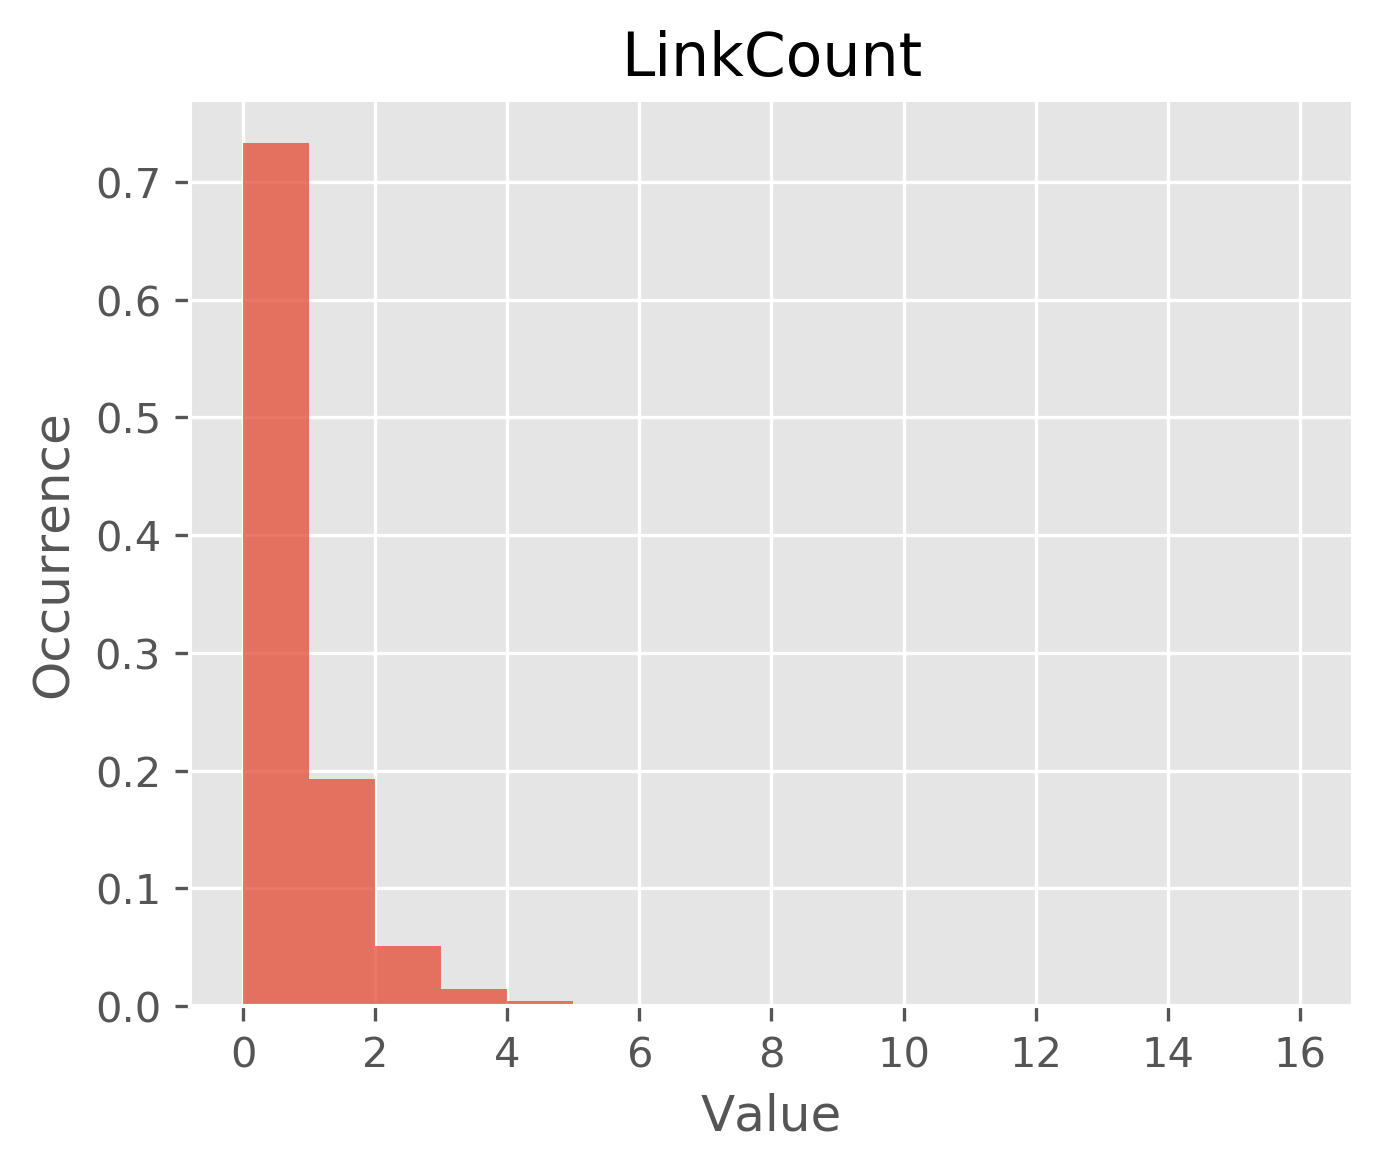

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=300) # width and height of the plot in inches

plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurrence')

n, bins, patches = plt.hist(X, normed=1, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)
plt.savefig(os.path.join(CHART_DIR, 'feat_hist_linkcount.png'), bbox_inches="tight")

Ok, so most posts don't contain a link at all, but let's try nevertheless...

## Training on LinkCount

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
scores = []
N_FOLDS = 10
from sklearn.utils import shuffle
#X, Y = shuffle(X, Y_orig, random_state=0)
X, Y = X, Y_orig
cv = KFold(n=len(X), n_folds=N_FOLDS)

for train, test in tqdm(cv, total=N_FOLDS):    
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Mean(scores)=0.48720	Stddev(scores)=0.01104


In [44]:
X.shape, Y.shape

((20000, 1), (20000,))

# Using more features

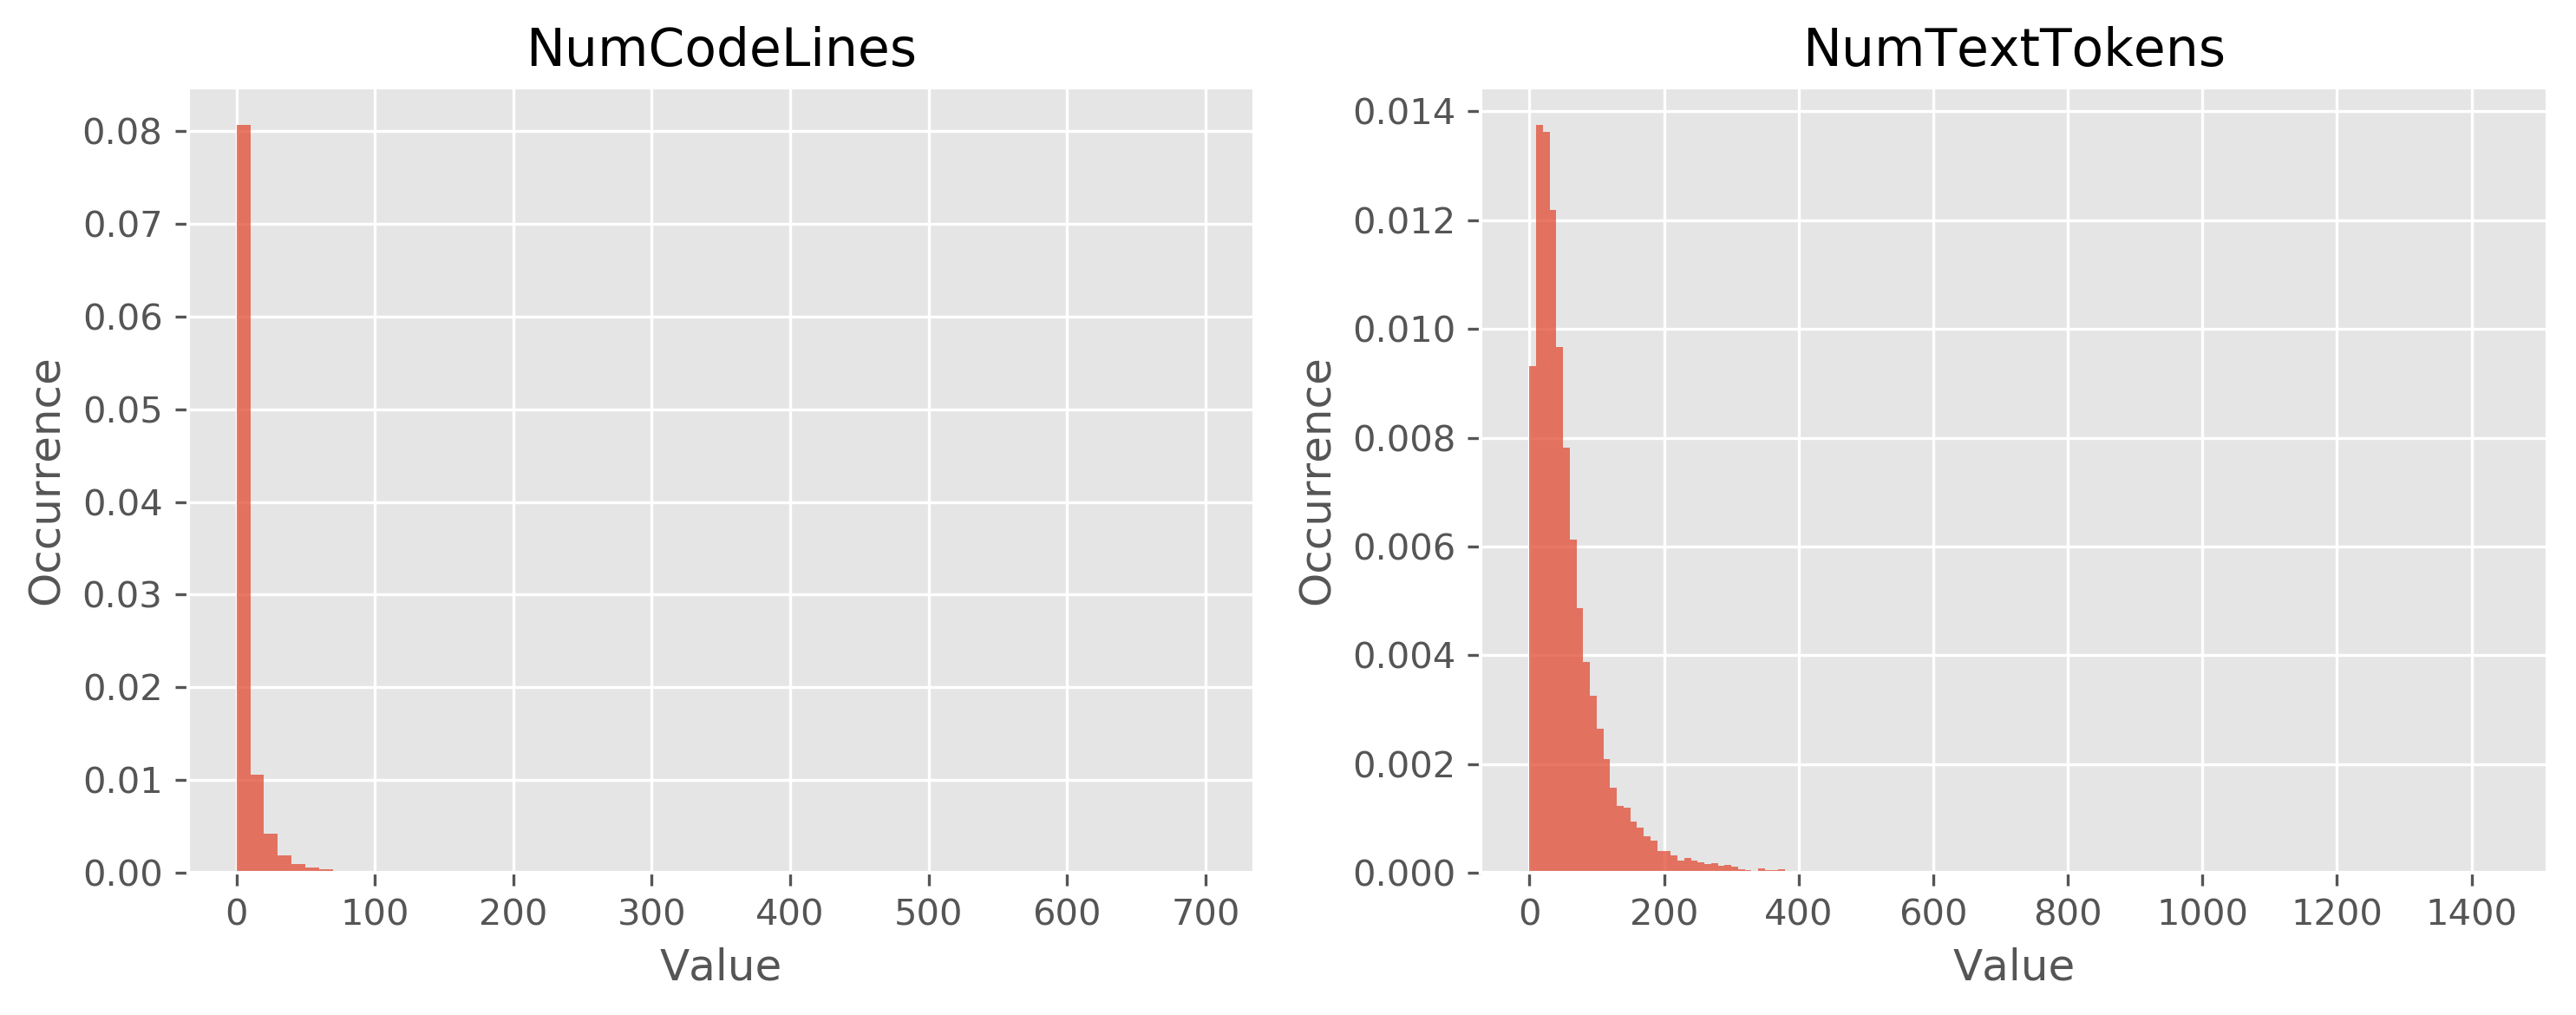

In [45]:
def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, normed=1, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    
    if not filename:
        filename = "feat_hist_%s.png" % name.replace(" ", "_")

    plt.savefig(os.path.join(CHART_DIR, filename))


plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')],
              'feat_hist_CodeLines_TextTokens.png');

In [46]:
def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers])

scores = []
from sklearn.utils import shuffle
#X, Y = shuffle(X, Y_orig, random_state=0)
X, Y = X, Y_orig
cv = KFold(n=len(X), n_folds=N_FOLDS)

for train, test in tqdm(cv, total=N_FOLDS):    
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Mean(scores)=0.55640	Stddev(scores)=0.01600


# If more features are good, even more features should be even better
Let's create some more text based features like average sentence and word length, how many words are CAPITALIZED or contain exclamation marks.

We simply fetch the post texts, calculate the statistics and add them to the `meta` dictionary.

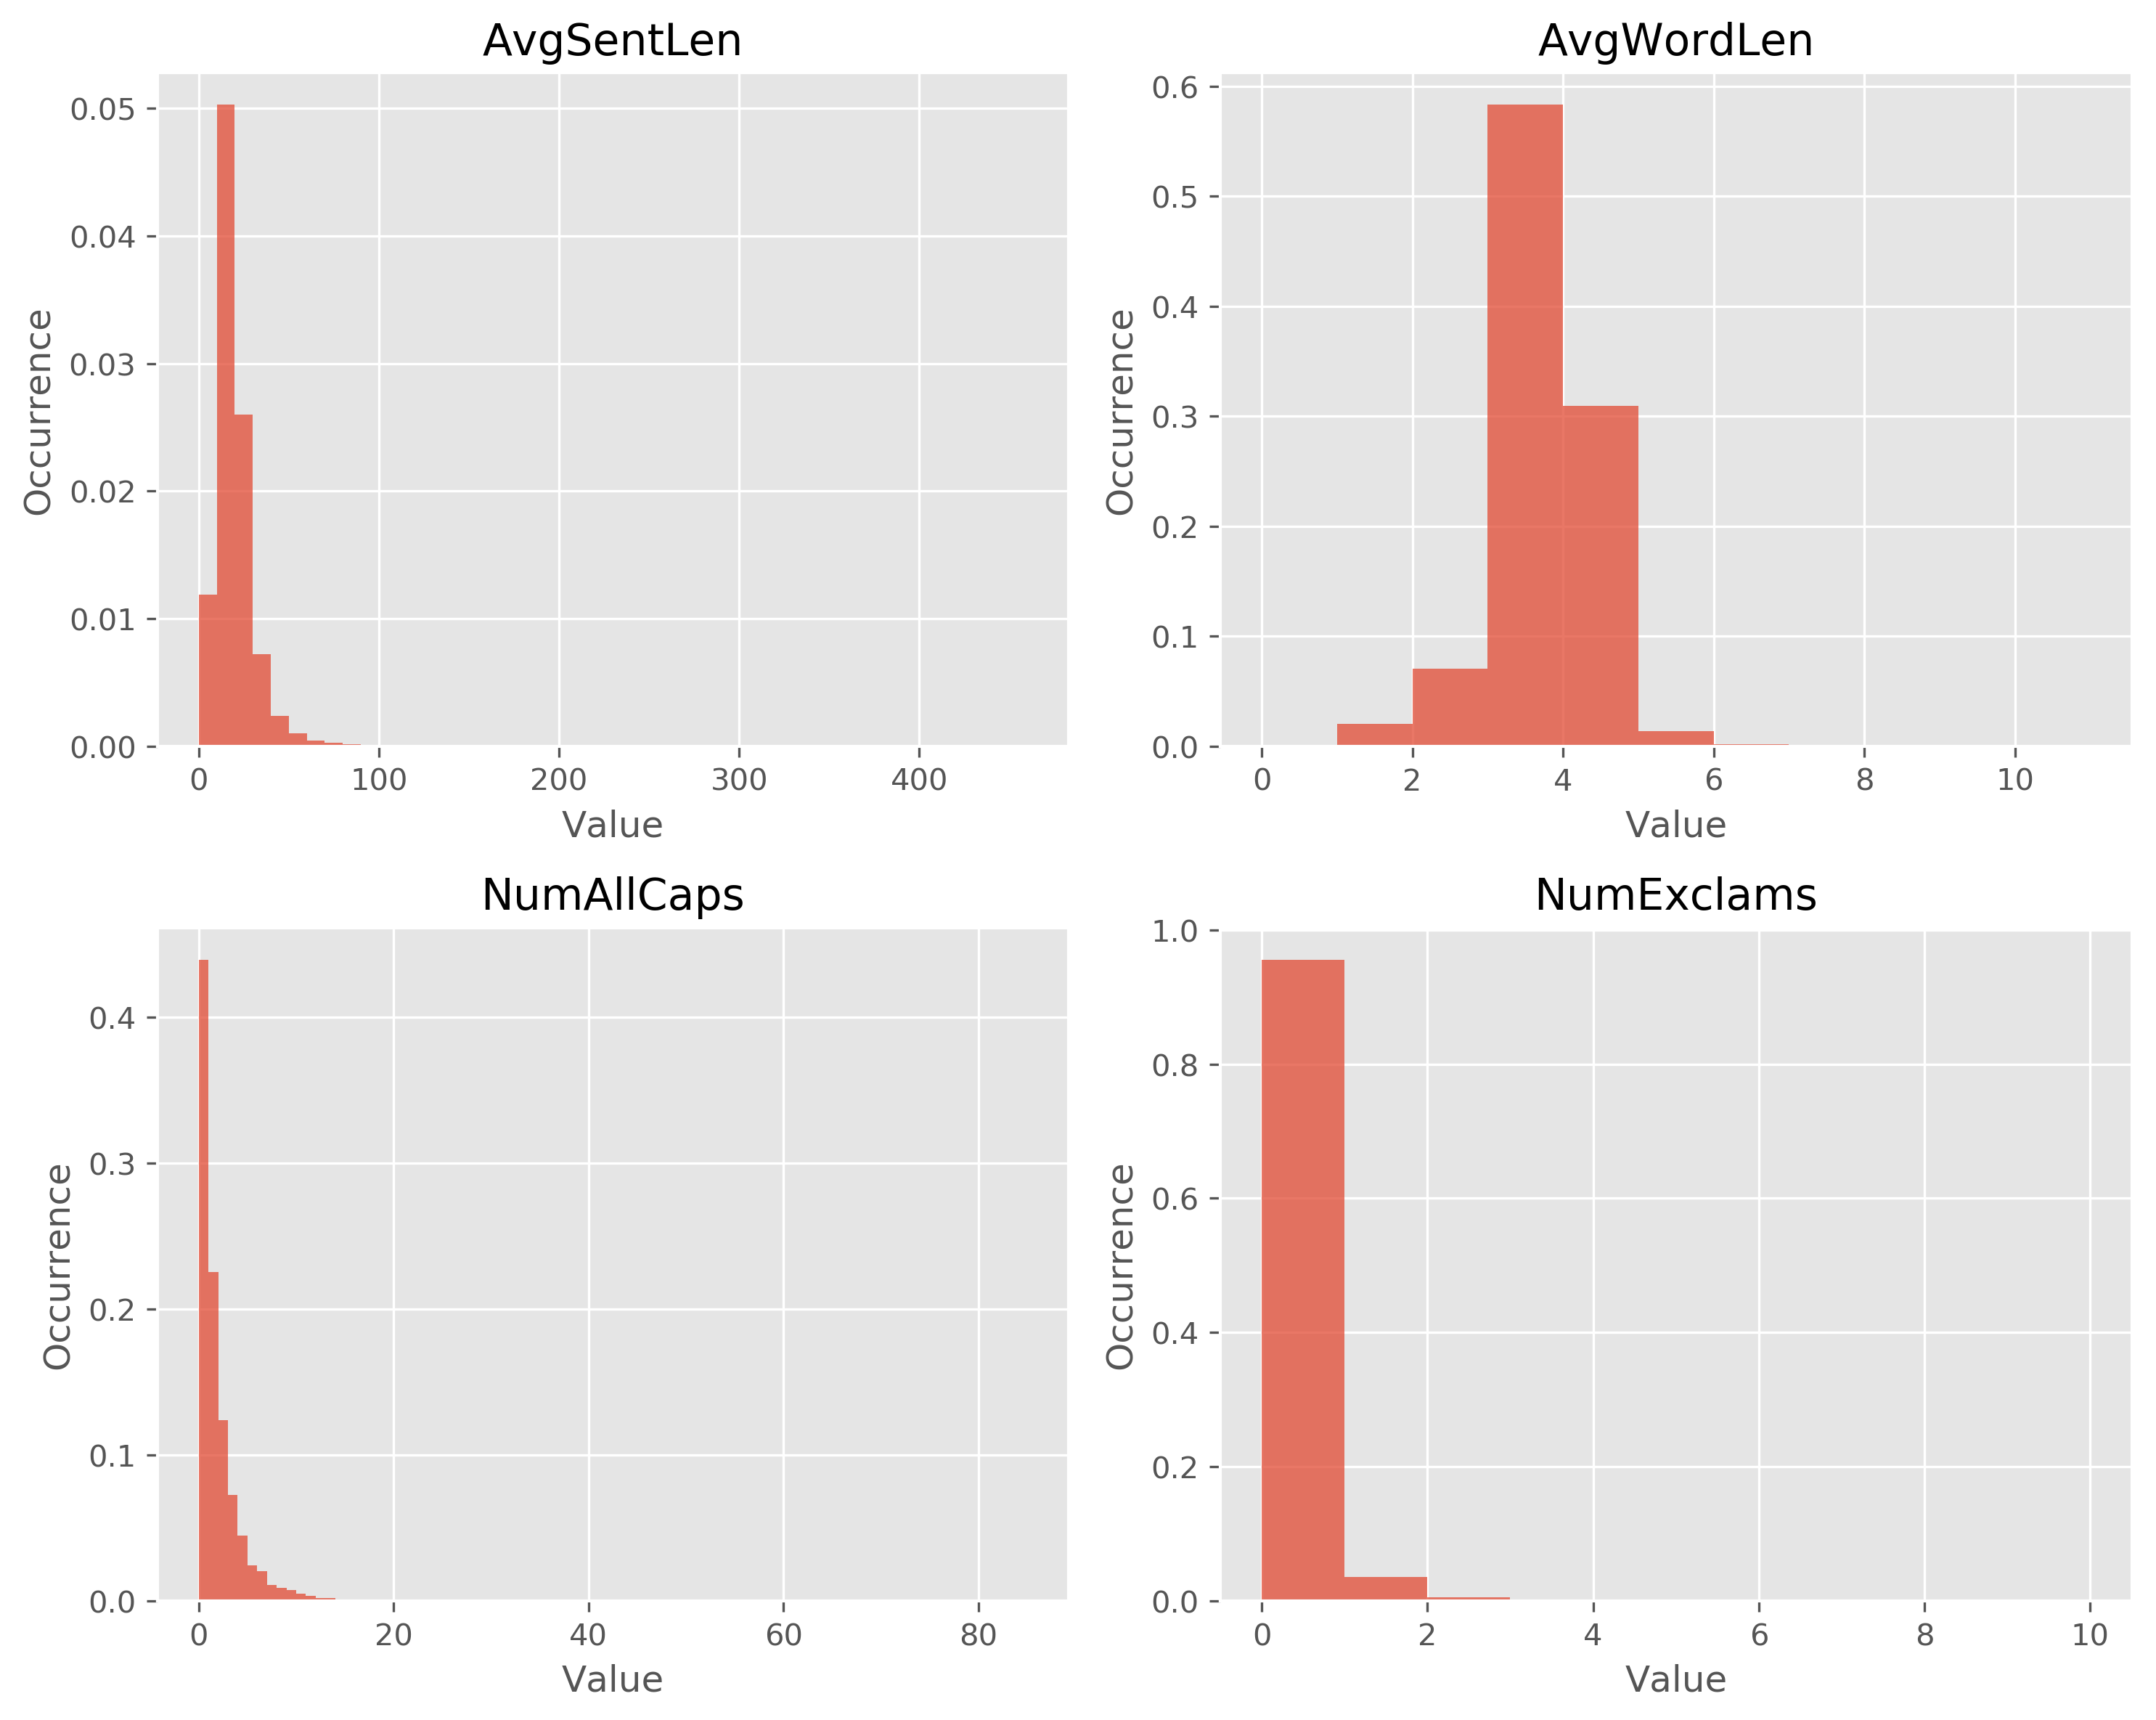

In [47]:
import nltk

def fetch_posts(fn, with_index=True, line_count=-1):
    count = 0

    for line in open(fn, "r"):
        count += 1
        if line_count > 0 and count > line_count:
            break

        Id, Text = line.split("\t")
        Text = Text.strip()

        if with_index:
            yield int(Id), Text

        else:
            yield Text
            
def add_sentence_features(m):
    for pid, text in fetch_posts(fn_chosen, with_index=True):
        if not text:
            m[pid]['AvgSentLen'] = m[pid]['AvgWordLen'] = m[pid]['NumAllCaps'] = m[pid]['NumExclams'] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              'feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams.png');
plt.tight_layout()


In [48]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers])

scores = []
from sklearn.utils import shuffle
X, Y = shuffle(X, Y_orig, random_state=0)
cv = KFold(n=len(X), n_folds=N_FOLDS)

for train, test in tqdm(cv, total=N_FOLDS):    
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Mean(scores)=0.55990	Stddev(scores)=0.00719


# High or low bias?

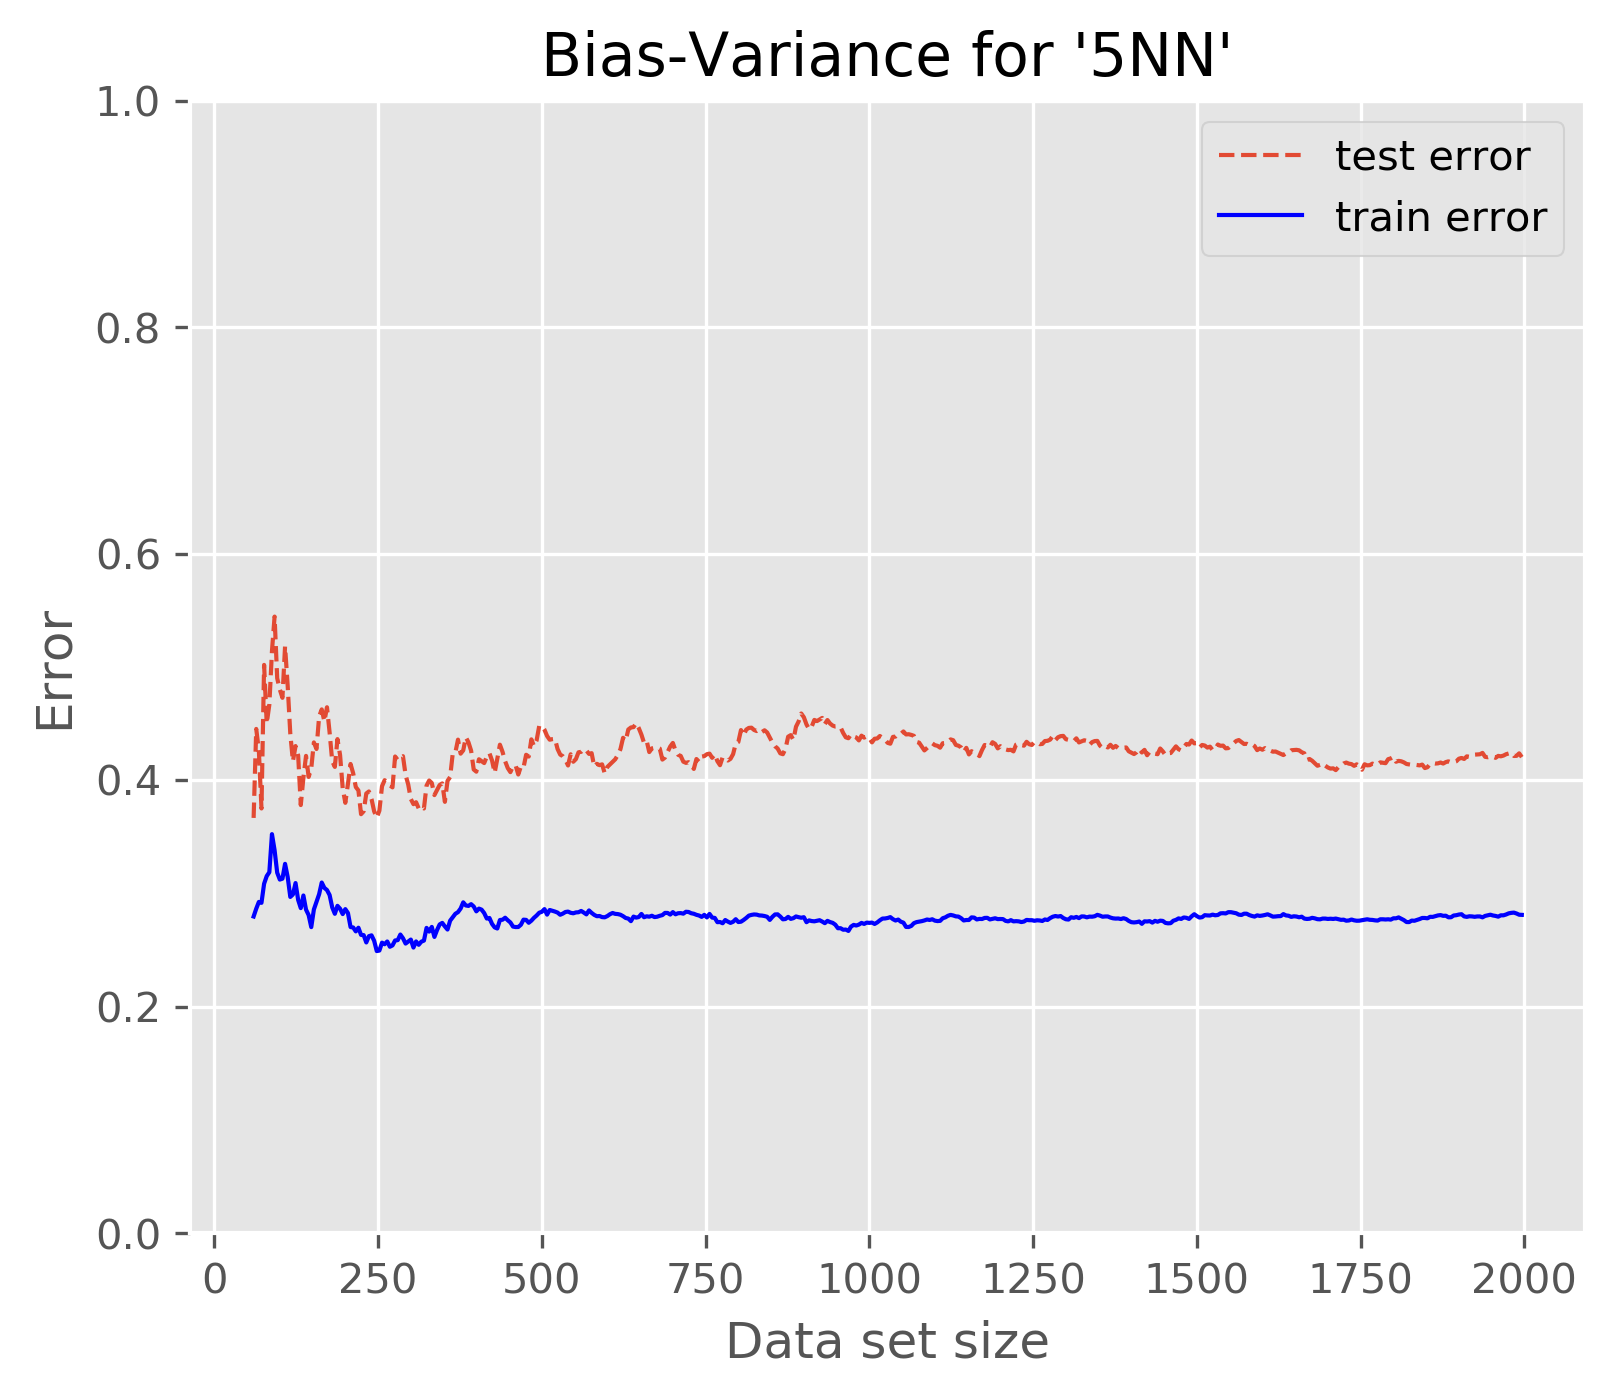

In [49]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance for '%s'" % name)
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")
    plt.savefig(os.path.join(CHART_DIR, "pr_" + filename + ".png"))

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5))
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1)

    plt.title('Feature importance for %s' % (name))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")
    plt.savefig(os.path.join(
        CHART_DIR, "feat_imp_%s.png" % filename), bbox_inches="tight")

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=False, classifying_answer='good', feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    cv = KFold(n=len(X), n_folds=10)

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        if False:
            print("Clone #%i" % fold_idx)
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], classifying_answer + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)

    summary = (name,
               np.mean(scores), np.std(scores),
               np.mean(roc_scores), np.std(roc_scores),
               np.mean(pr_scores), np.std(pr_scores))
        
    precisions = precisions[medium]
    recalls = recalls[medium]
    thresholds = np.hstack(([0], thresholds[medium]))
    idx80 = precisions >= 0.8
    # print("P=%.2f R=%.2f thresh=%.2f" % (precisions[idx80][0], recalls[idx80][0], thresholds[idx80][0]))

    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(60, 2000, 4)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, summary = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

bias_variance_analysis(KNeighborsClassifier, {'n_neighbors': 5}, "5NN", X, Y)
plt.savefig(os.path.join(CHART_DIR, "bv_5NN_all.png"), bbox_inches="tight")

Maybe simplifying the feature space helps. Let's try out to use only `LinkCount` and `NumTextTokens`:

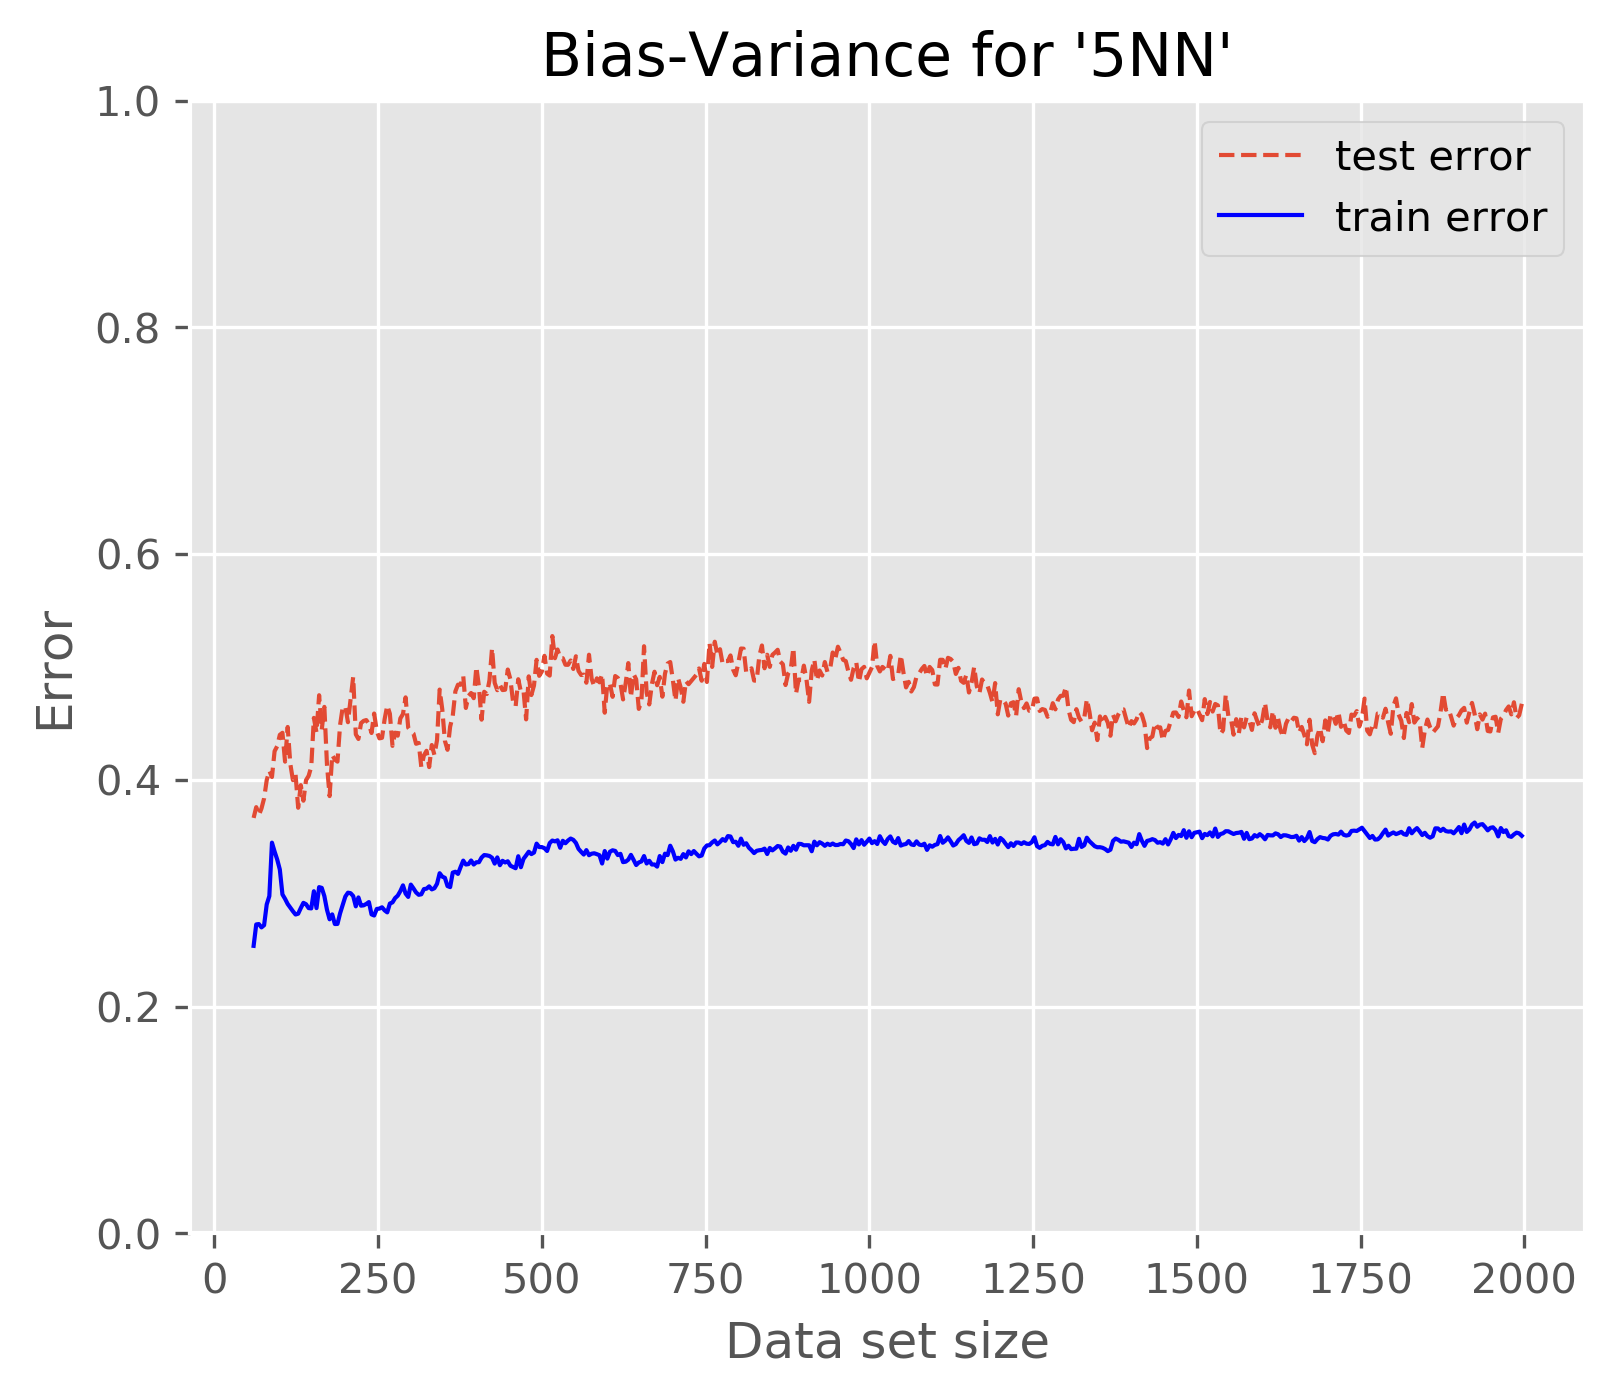

In [50]:
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers])
X_simp, Y_simp = shuffle(X_simp, Y_orig, random_state=0)

bias_variance_analysis(KNeighborsClassifier, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)
plt.savefig(os.path.join(CHART_DIR, "bv_5NN_simp.png"), bbox_inches="tight")

Does it help to reduce the model complexity by increasing $k$?

In [51]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
    train_error, test_error, summary = measure(KNeighborsClassifier, {'n_neighbors': k}, "%iNN" % k, X, Y)
    print('%d\t%.4f\t\t%.4f'%(k,summary[1], summary[2]))

k	mean(scores)	stddev(scores)
5	0.5599		0.0072
10	0.5698		0.0073
40	0.5927		0.0083


It helps a bit, but do we really want to compare with 40 different samples each time?

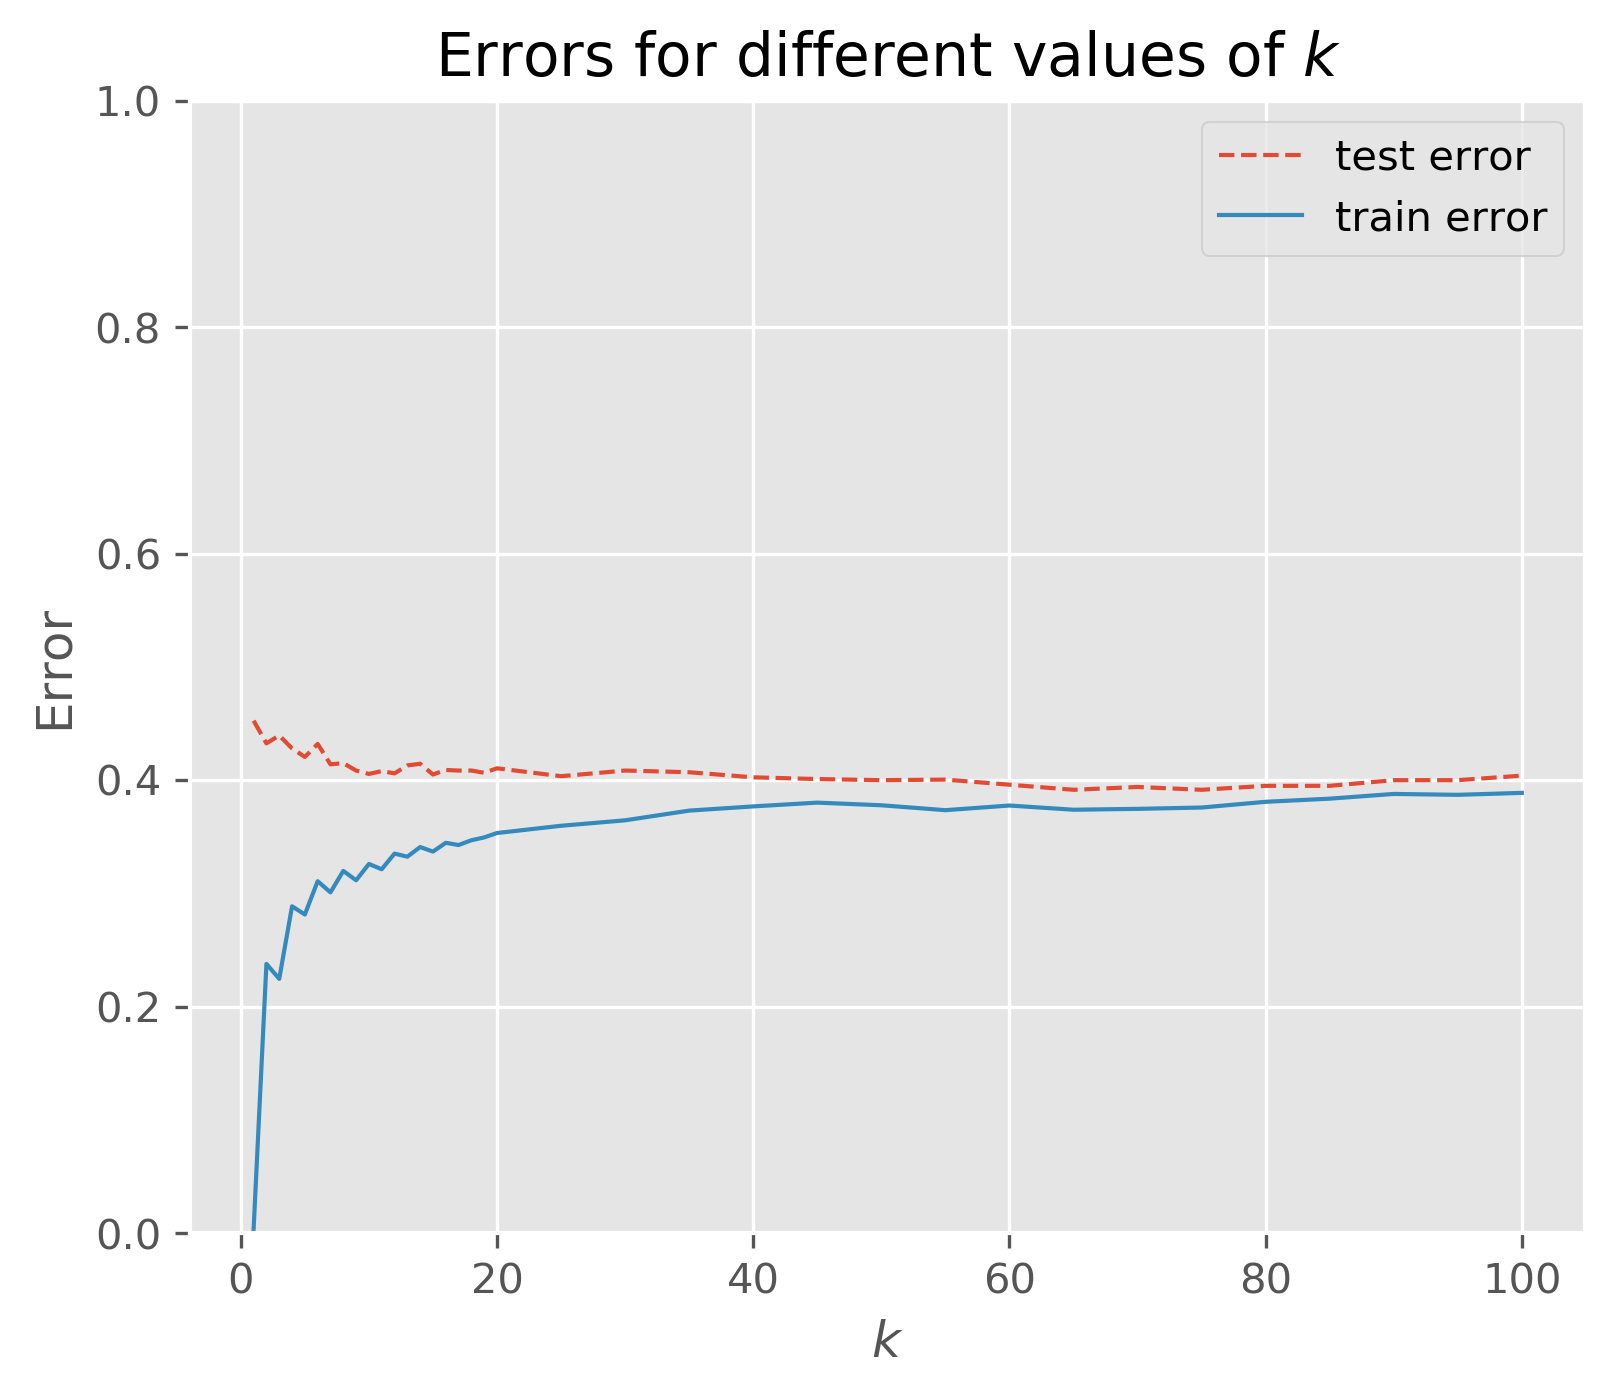

In [52]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    plt.savefig(os.path.join(CHART_DIR, "kcomplexity.png"), bbox_inches="tight")

def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, summary = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)

k_complexity_analysis(KNeighborsClassifier, X, Y)    

And we won't get much better with increasing values of $k$.

# Using logistic regression
Creating some toy data to visualize how logistic regression works...

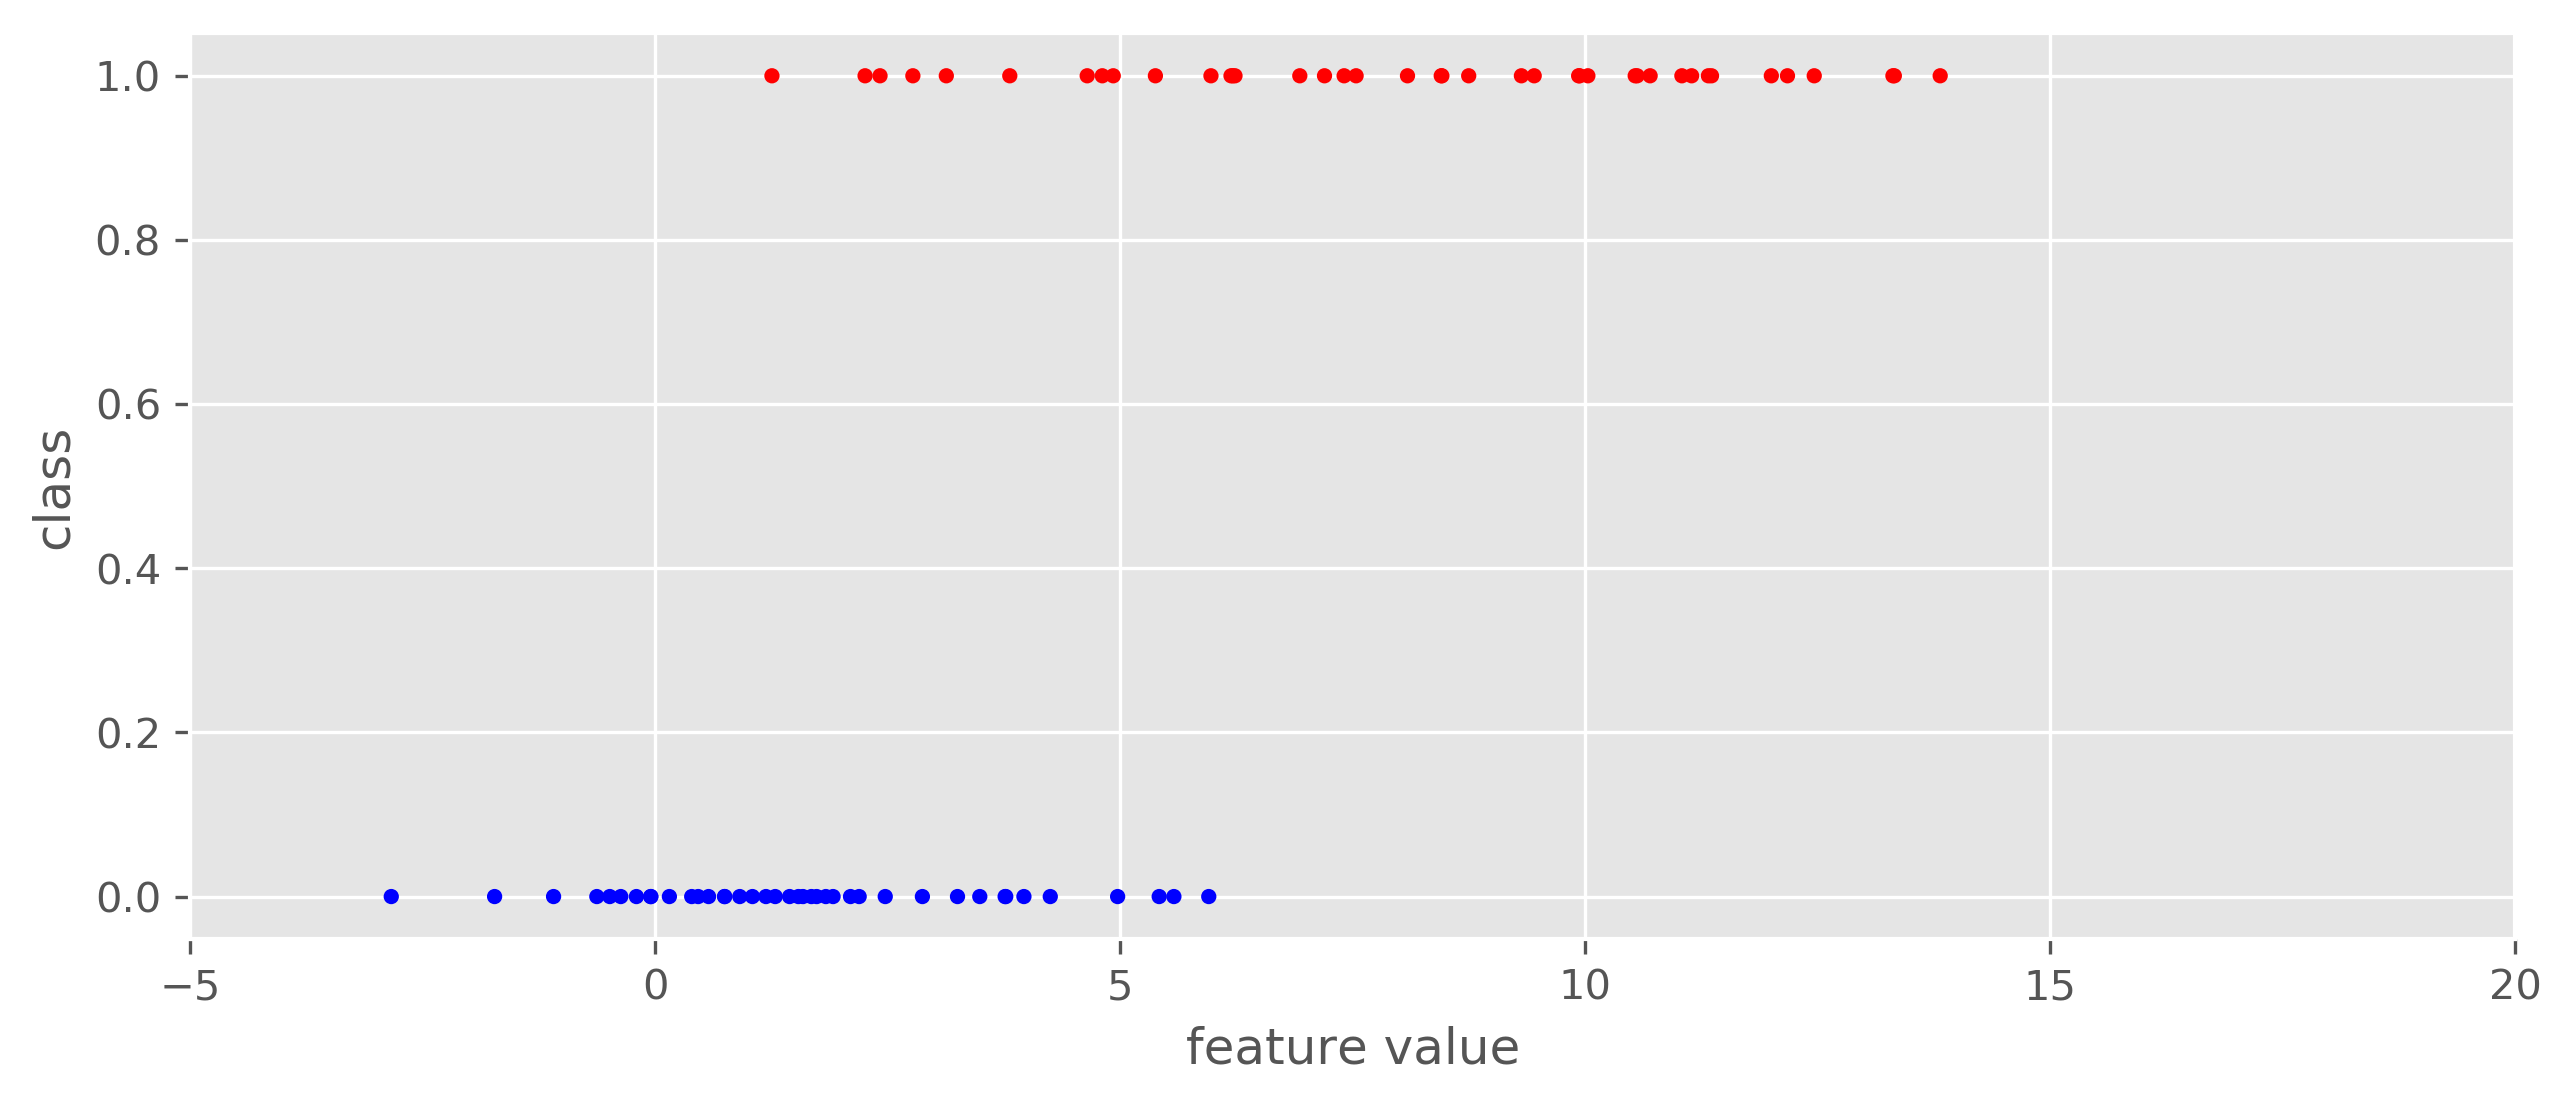

In [53]:
from scipy.stats import norm

np.random.seed(3)

NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2),
              norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS),
               np.ones(NUM_PER_CLASS))).astype(int)


plt.figure(figsize=(10, 4), dpi=300)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("feature value")
plt.ylabel("class")
    
plt.savefig(os.path.join(CHART_DIR, "log_reg_example_data.png"), bbox_inches="tight")

In [54]:
def lr_model(clf, X):
    '''
    https://en.wikipedia.org/wiki/Logistic_regression
    '''
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

X_test = np.arange(-5, 20, 0.1)
from sklearn.linear_model import LogisticRegression

logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %(lr_model(logclf, -1), lr_model(logclf, 7)))

[ 0.09437188] [ 1.80094112]
P(x=-1)=0.05	P(x=7)=0.85


NameError: name 'y' is not defined

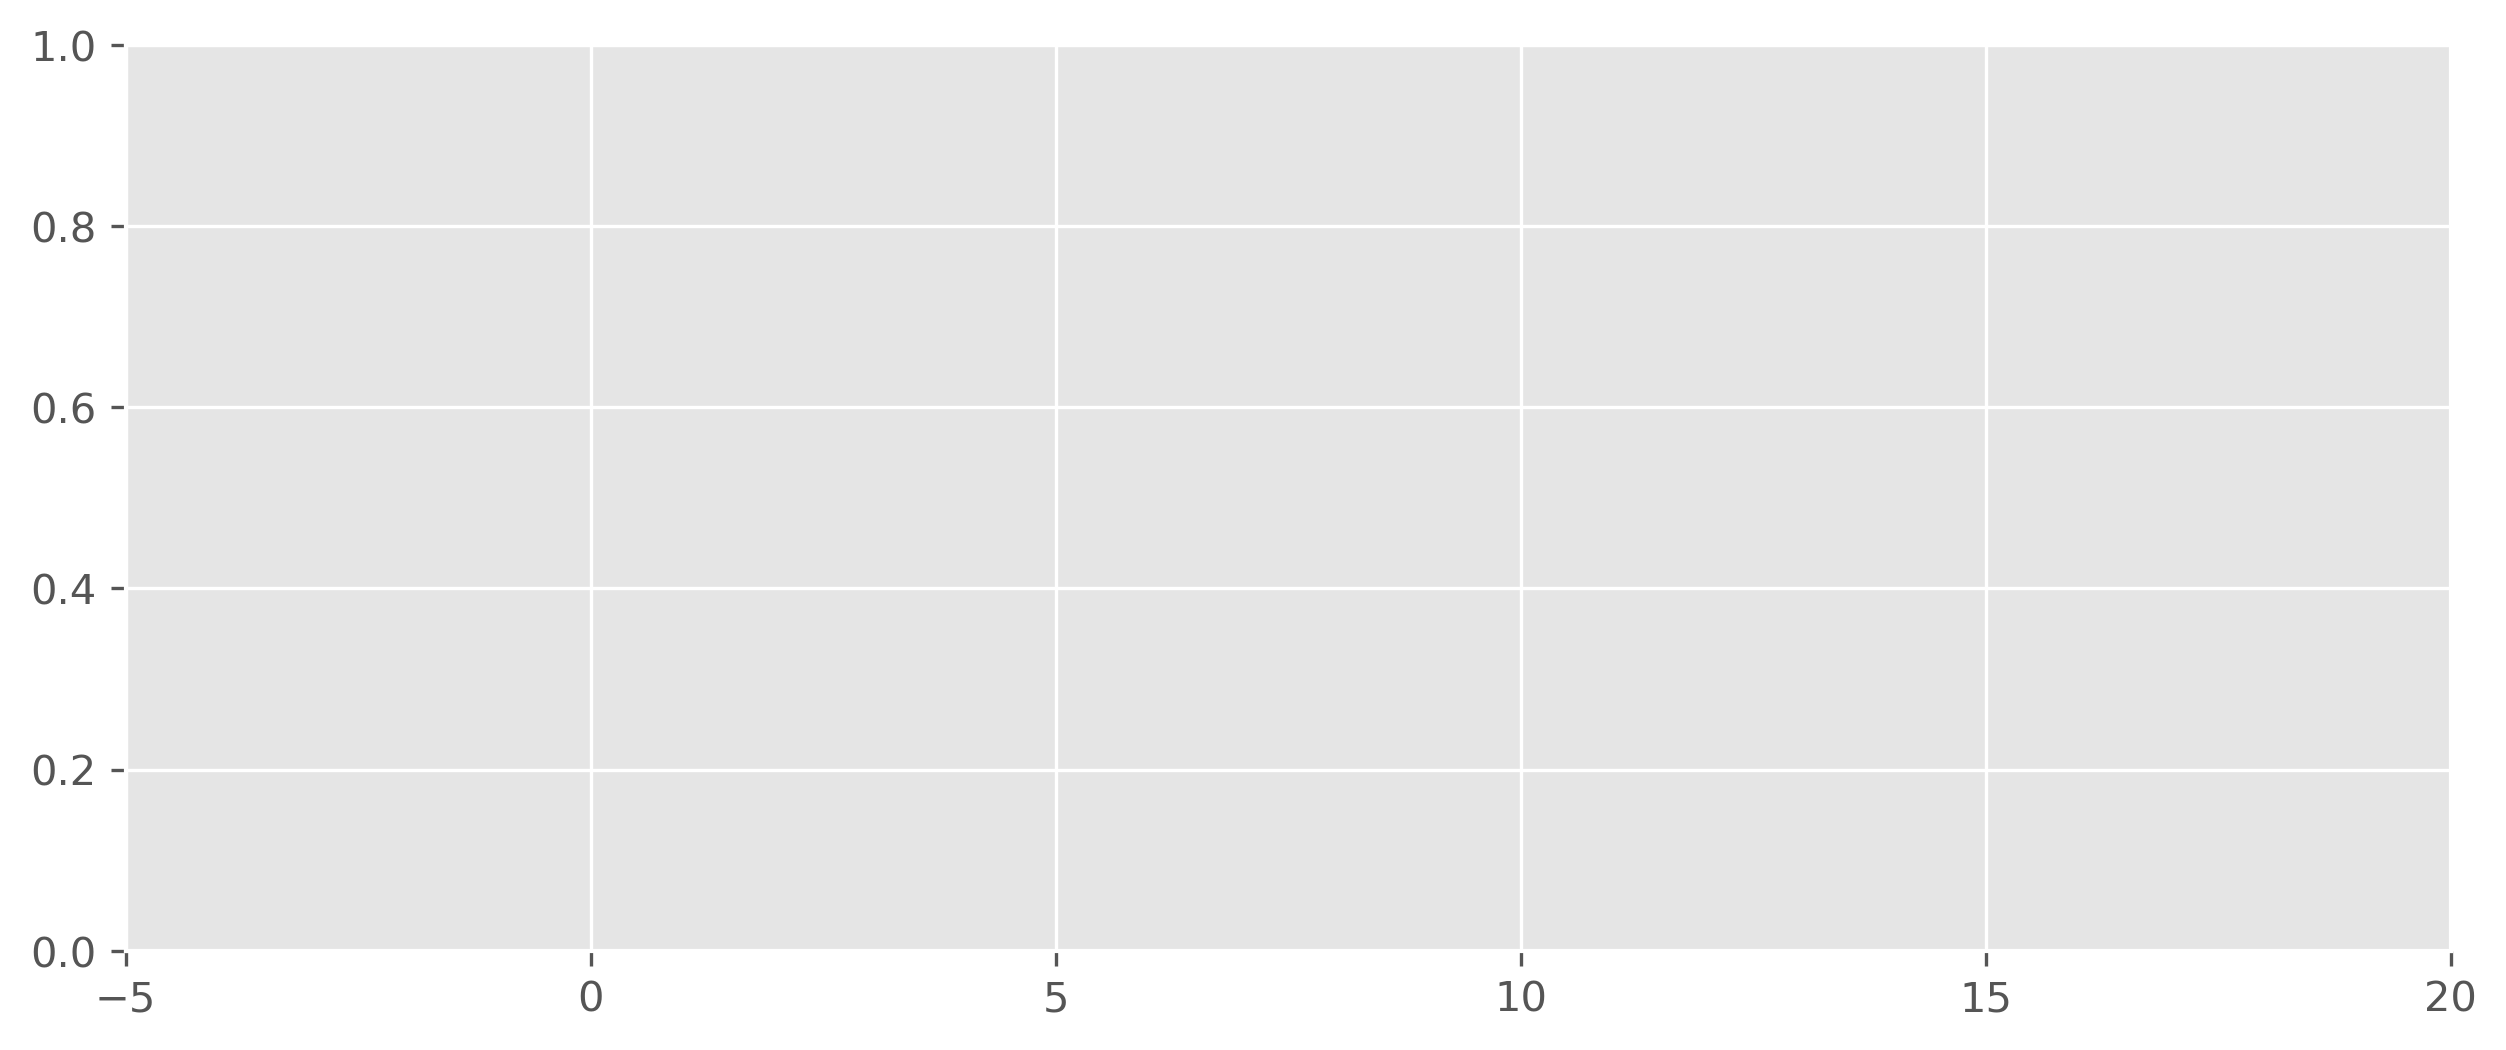

In [55]:
plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y], s=5)
plt.plot(X_test, lr_model(logclf, X_test).ravel(), c='green')
plt.plot(X_test, np.ones(X_test.shape[0]) * 0.5, "--")
plt.xlabel("feature value")
plt.ylabel("class")
plt.grid(True)
plt.savefig(os.path.join(CHART_DIR, "log_reg_example_fitted.png"), bbox_inches="tight")

X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)
plt.savefig(os.path.join(CHART_DIR, "log_reg_log_odds.png"), bbox_inches="tight")

In [ ]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    train_error, test_error, summary = measure(LogisticRegression, {'penalty': 'l2', 'C': C}, name, X, Y)

    print('%.2f\t%.4f\t\t%.4f'%(C,summary[1], summary[2]))

In [ ]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams',
    'NumImages'
))
C = 0.01
classifying_answer = "good"
#classifying_answer = "poor"

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor)
    
name = "LogReg C=%.2f" % C
measure(LogisticRegression, {'penalty': 'l2', 'C': C}, name, X_new, Y_good, plot=True, classifying_answer='good', feature_names=feature_names)
measure(LogisticRegression, {'penalty': 'l2', 'C': C}, name, X_new, Y_poor, plot=True, classifying_answer='poor', feature_names=feature_names)

In [ ]:
X_orig

In [ ]:
old=json.load(open(r"C:\repo\ML_Book\BuildingMachineLearningSystemsWithPython\ch04_3rd\data\old\chosen-meta.json"))
new=json.load(open(r"C:\repo\ML_Book\BuildingMachineLearningSystemsWithPython\ch04_3rd\data\chosen-meta.json"))
              

In [ ]:
o,n = set(old.keys()), set(new.keys())

In [ ]:
len(o-n)

In [ ]:
len(o-n)